# 5) Using the data in the link below, attempt to model a customer’s propensity to join our loyalty program

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import resample

C:\Users\mhuh22\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Read, clean, and preview the data
data = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/customers_data.csv')
data.drop('Unnamed: 0',axis=1, inplace=True)
data.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,male,no,31.0,35.0,False
1,65.16,male,yes,23.0,61.0,False
2,40.60,female,no,36.0,49.0,False
3,38.01,male,yes,47.0,57.0,False
4,22.32,female,yes,5.0,39.0,False


In [3]:
# View statistics on dataset
data.describe()

,purch_amt,age,days_since_last_purch
count,120000.000000,120000.000000,120000.000000
mean,44.036234,25.803008,56.605908
std,20.473148,10.153072,16.422187
min,-43.950000,-22.000000,-9.000000
25%,30.210000,19.000000,45.000000
50%,43.970000,26.000000,57.000000
75%,57.830000,33.000000,68.000000
max,142.200000,71.000000,125.000000


In [4]:
# Drop all rows with negative values
# The 3 columns above should not have negative values
for col in data.select_dtypes(include=[np.number]).columns.tolist()[1:]:
    data = data[data[col] >= 0]

C:\Users\mhuh22\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


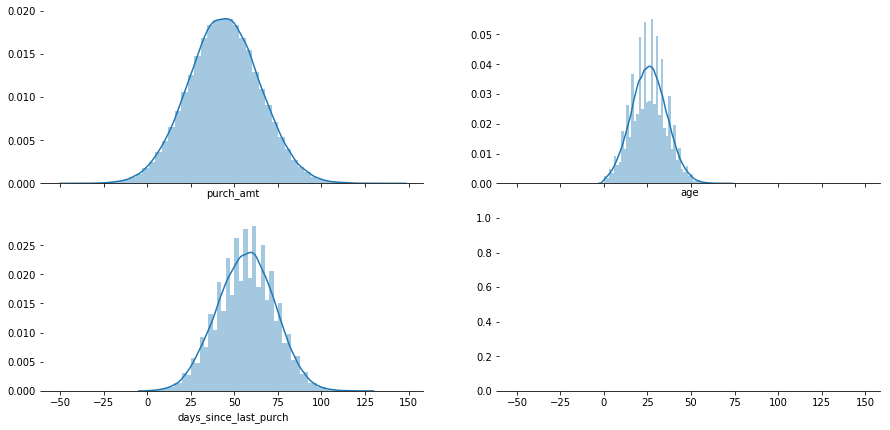

In [5]:
# View all numeric values
f, axes = plt.subplots(2,2, figsize=(15,7), sharex=True)
sns.despine(left=True)

sns.distplot(data['purch_amt'], ax=axes[0, 0])

sns.distplot(data['age'], ax=axes[0, 1])

sns.distplot(data['days_since_last_purch'], ax=axes[1, 0])

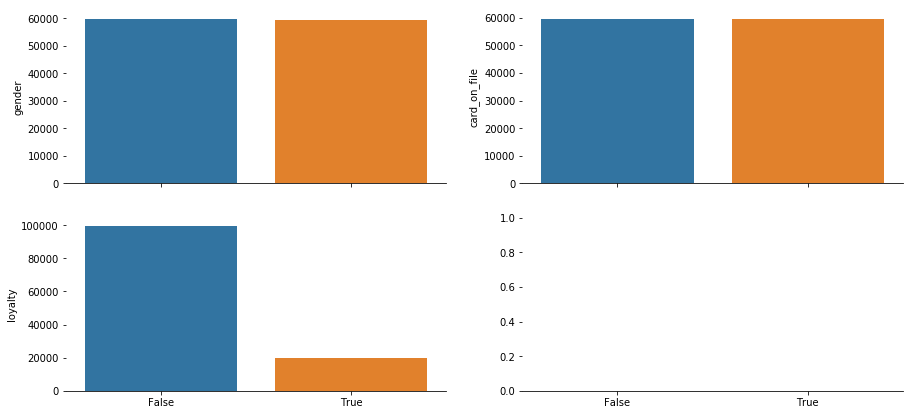

In [6]:
# View all binary values
f, axes = plt.subplots(2,2, figsize=(15,7), sharex=True)
sns.despine(left=True)

sns.barplot(x = data['gender'].value_counts().index,
            y = data['gender'].value_counts(), 
            ax=axes[0, 0],)

sns.barplot(x = data['card_on_file'].value_counts().index,
            y = data['card_on_file'].value_counts(),
            ax = axes[0, 1])

sns.barplot(x = data['loyalty'].value_counts().index,
            y = data['loyalty'].value_counts(),
            ax = axes[1,0])

In [7]:
# Binarize variables
gender_map = {'male': 0, 'female': 1}
card_on_file_map = {'no': 0, 'yes': 1}
loyalty_map = {False: 0, True: 1}

data['gender'] = data['gender'].map(lambda x: gender_map[x])
data['card_on_file'] = data['card_on_file'].map(lambda x: card_on_file_map[x])
data['loyalty'] = data['loyalty'].map(lambda x: loyalty_map[x])

In [8]:
# Preview the data before modelling
data.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,0,0,31.0,35.0,0
1,65.16,0,1,23.0,61.0,0
2,40.60,1,0,36.0,49.0,0
3,38.01,0,1,47.0,57.0,0
4,22.32,1,1,5.0,39.0,0


In [9]:
# Declare input and output variables
X = data.drop(['loyalty'], axis=1)
y = data['loyalty']

# Divide the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)

In [10]:
# Upsample loyalty so that both values are equally represented 
loyalty_false = data[data.loyalty==False]
loyalty_true = resample(data[data.loyalty==True], replace=True, n_samples = len(loyalty_false))
data = pd.concat([loyalty_false, loyalty_true])

In [11]:
# Declare input and output variables
X_u = data.drop(['loyalty'], axis=1)
y_u = data['loyalty']

# Divide the dataset into training and testing datasets
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u, test_size=0.3, stratify = y_u, random_state=0)

In [12]:
## Logistic regression model
lr = LogisticRegression()

# Parameters for logistic regression model
param_grid = {'solver': ['lbfgs', 'liblinear'],
             'C': [1, 10, 100, 1000]}

lr_grid = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1)

lr_grid.fit(X_train_u, y_train_u)

lr_train = cross_val_score(lr_grid, X_train_u, y_train_u, cv=5, n_jobs=-1)
lr_test = cross_val_score(lr_grid, X_test, y_test, cv=5, n_jobs=-1)

print('Logistic regression train score: {:.5f}(+/- {:.2f})\n'.format(lr_train.mean(), lr_train.std()*2))
print('Logistic regression test score: {:.5f}(+/- {:.2f})\n'.format(lr_test.mean(), lr_test.std()*2))

y_pred_lr = lr_grid.predict(X_test)
print('Confusion matrix:\n\n', confusion_matrix(y_test, y_pred_lr))

Logistic regression train score: 0.79508(+/- 0.00)

Logistic regression test score: 0.87016(+/- 0.00)

Confusion matrix:

 [[23541  6293]
 [ 1160  4827]]


In [13]:
# Random forest model
rfc = ensemble.RandomForestClassifier()

param_grid = {'n_estimators' : [10, 20, 40, 60],
              'class_weight': ['balanced', 'balanced_subsample'],
             'oob_score': [True, False]}

# Run grid search to find ideal parameters
rfc_grid = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)

# Fit the model to the data
rfc_grid.fit(X_train_u, y_train_u)

rfc_train = cross_val_score(rfc_grid, X_train_u, y_train_u, cv=5, n_jobs=-1)
rfc_test = cross_val_score(rfc_grid, X_test, y_test, cv=5, n_jobs=-1)
print('Random forest train score: {:.5f}(+/- {:.2f})\n'.format(rfc_train.mean(), rfc_train.std()*2))
print('Random forest test score: {:.5f}(+/- {:.2f})\n'.format(rfc_test.mean(), rfc_test.std()*2))

y_pred_rfc = rfc_grid.predict(X_test)
print('Confusion matrix:\n\n', confusion_matrix(y_test, y_pred_rfc))

Random forest train score: 0.91685(+/- 0.00)

Random forest test score: 0.85428(+/- 0.00)

Confusion matrix:

 [[26185  3649]
 [   84  5903]]
